In [0]:
import tensorflow as tf

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

In [4]:
cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()
print("x_train.shape:", x_train.shape)
print("y_train.shape", y_train.shape)

170500096/170498071 [==============================] - 13s 0us/step
x_train.shape: (50000, 32, 32, 3)
y_train.shape (50000,)


In [0]:
K = len(set(y_train))

In [0]:
i = Input(shape=x_train[0].shape)
# x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
# x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
# x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)

#Parecido a VGG en el sentido que hay grupos de convolution seguidos por poolings
#Saco la normalizacion del dropout porque creo me estaba sacando features y agrego batch normalization x-mean/sd. Aprende automaticamente si tiene o no que normalizar.
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i) #
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

model = Model(i, x)

In [0]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496 

In [10]:
batch_size = 32

#Data augmentation
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True) #se lo voy a pasar al train generator y me va a 
#girar, mover y flipear las imagenes entre otras cosas. Me genera mas data basicamente. Como las distorsiones que meti para el dataset en andrewng ml. Ojo con los flips, si giras un 9 es un 6

train_generator = data_generator.flow(x_train, y_train, batch_size) #entreno en batches, no todo de 1, por epoch (porque uso batch gradient descent)

steps_per_epoch = x_train.shape[0] // batch_size # n / bs

r = model.fit(train_generator, validation_data=(x_test, y_test), steps_per_epoch=steps_per_epoch, epochs=50)
#tarda un millon de años mas, pero ya en el epoch 12 tengo un test accuracy super alto

Epoch 1/50
1562/1562 [==============================] - 28s 18ms/step - loss: 0.5446 - accuracy: 0.8291 - val_loss: 0.5221 - val_accuracy: 0.8369
Epoch 2/50
1562/1562 [==============================] - 28s 18ms/step - loss: 0.4473 - accuracy: 0.8548 - val_loss: 0.4880 - val_accuracy: 0.8457
Epoch 3/50
1562/1562 [==============================] - 27s 17ms/step - loss: 0.4101 - accuracy: 0.8629 - val_loss: 0.4715 - val_accuracy: 0.8494
Epoch 4/50
1562/1562 [==============================] - 27s 17ms/step - loss: 0.3868 - accuracy: 0.8702 - val_loss: 0.5074 - val_accuracy: 0.8486
Epoch 5/50
1562/1562 [==============================] - 27s 18ms/step - loss: 0.3716 - accuracy: 0.8764 - val_loss: 0.4440 - val_accuracy: 0.8584
Epoch 6/50
1562/1562 [==============================] - 27s 18ms/step - loss: 0.3548 - accuracy: 0.8806 - val_loss: 0.4508 - val_accuracy: 0.8585
Epoch 7/50
1562/1562 [==============================] - 27s 17ms/step - loss: 0.3356 - accuracy: 0.8881 - val_loss: 0.4758 -

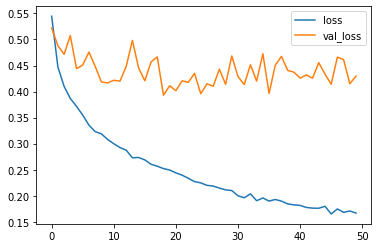

In [11]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

#No estoy muy seguro que significa, pero ambos son valores super bajos

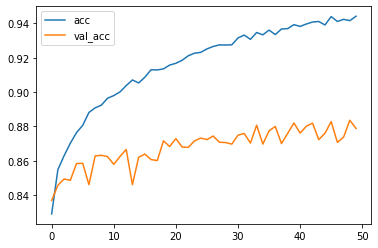

In [12]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

#Bastante bueno, aunque no entiendo porque no entiendo porque no convergen mas linealmente

Confusion matrix, without normalization
[[897  13  37  14   6   0  10   7   9   7]
 [  8 969   2   2   1   0   1   0   0  17]
 [ 21   1 816  33  48  18  41  15   4   3]
 [  6   3  35 761  44  92  38  14   4   3]
 [  6   1  23  25 886  10  28  20   0   1]
 [  5   0  21  76  36 817  24  20   1   0]
 [  3   1  24  24   6   5 932   3   1   1]
 [  5   0  11  17  21  30   6 906   1   3]
 [ 43  23  11   7   2   2  11   5 878  18]
 [ 11  43   1   5   1   0   8   1   4 926]]


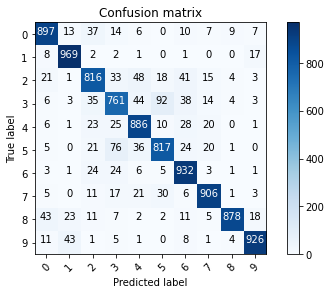

In [13]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

#espectacularmente mejor. Las confusiones son pocas y coherentes para esta resolucion (perro/gato etc)

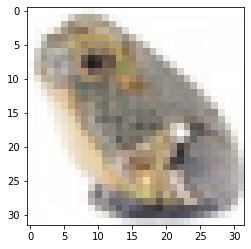

In [19]:
# Me robe un poco de codigo para ver los errores. Me parecen super coherentes
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')

In [23]:
!mkdir -p CIFAR10_DataAug&BM #lo guardo
model.save('CIFAR10_DataAug&BM/my_model') 

/bin/bash: BM: command not found
INFO:tensorflow:Assets written to: CIFAR10_DataAug&BM/my_model/assets


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
